<div style="background:#a8eced">
    <h1>Team OCEAN- Visualisation</h1>
    <h3>Michel Dit Ferrer Paul, Bournet Raphaël, Coquisart Jérôme, Garcia Pierre, Dahalani Luqman, Marchment George</h3>
    <h2>Plankton classification challenge</h2>
<a href="https://github.com/George-Marchment/OCEAN">Link to our Github</a>
</center>
</div>

<div style="background:#f3f47b">
    <h1>
<h1> This is preliminary code
    <h1>
</div>

In [1]:
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
#data_dir = 'sample_data'              # Change this to the directory where you put the input data
data_dir = './public_data'          # The sample_data directory should contain only a very small subset of the data
data_name = 'plankton'
!ls $data_dir*
from data_io import read_as_df
data = read_as_df(data_dir  + '/' + data_name)                # The data are loaded as a Pandas Data Frame
from sklearn import preprocessing
data_target = data.copy()
le = preprocessing.LabelEncoder()
data_target.target = le.fit_transform(data_target.target.values)

<div style="background:#f3f47b">
    <h1>
<h1> The goal of this section is to find different patterns in the data to be able to better identify the different  plankton
    <h1>
</div>

<div style="background:#f36864">

<h1>
We cannot conclude anything from this function/ code, we will still leave it as a comment

</div>

In [6]:
def valueEnFonctionTarget(value, target):
    import numpy as np
    valeur=0
    if value== 'mean':
        valeur=200
    if value== 'variance':
        valeur=201
    if value== 'outline_length':
        valeur=202
    
    tab_other=[]
    for i in thing:
        if(i[203]==target):
            tab_other.append(i)
    
    mean_other=[]
    for i in tab_other:
        mean_other.append(i[valeur])
    tab= np.linspace(1, len(mean_other), len(mean_other))


    fig, ax = plt.subplots()
    ax.plot(tab, mean_other)
    plt.title(value +' pour les '+target)
    
    

In [34]:
"""thing= data.values
values=['mean', 'varaince', 'outline_length']
targets=['chaetognatha', 'copepoda', 'euphausiids', 'fish_larvae', 'limacina', 'medusae', 'other' ]
for target in targets:
    for value in values:
        valueEnFonctionTarget(value, target)"""

"thing= data.values\nvalues=['mean', 'varaince', 'outline_length']\ntargets=['chaetognatha', 'copepoda', 'euphausiids', 'fish_larvae', 'limacina', 'medusae', 'other' ]\nfor target in targets:\n    for value in values:\n        valueEnFonctionTarget(value, target)"

<div style="background:#93f189">
<h1>Original Graph<h1>
<br>Author: George Team Ocean<br>
<br>Last revision Date: 04/04/2020<br>
<br>Description: Visualisation des clusters, pour observer des patterns: pour faire cela on utilise KMeans<br>

</div>

In [35]:
#On doit avoir 0<=x<=202 et 0<=y<=202
def kmeansThing(x, y):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    from sklearn.datasets import make_blobs
    
    test= data.copy()
    del test['target']
    tab= test.values
    names= list(test)

    plt.figure(figsize=(12, 12))

    y_pred = KMeans(n_clusters=7).fit_predict(tab)
    
    
    #tests
    test= data['mean']
    assert (len(names)==203), "Problem names"
    assert (tab.shape==(10752, 203)), "Problem shape tab"
    assert (tab[:, 200][0]==test[:][0]), "Problem de Conversion"


    plt.subplot(221)
    plt.scatter(tab[:, x], tab[:, y], c=y_pred)
    plt.title(names[y]+ ' en fonctin de '+names[x])
    plt.xlabel("outline_length")
    plt.ylabel("mean")

    plt.show()

    

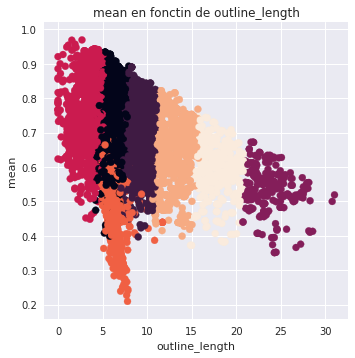

In [36]:
kmeansThing(202, 200)

In [16]:
#Test pour limacina
test= data.copy()
tab= test.values
tab[0][203]
somme=0
somme_total=0
for i in range(len(tab)):
    if(tab[i][202]>4.5 and tab[i][202]<10 and tab[i][200]<0.51 ):
        if(tab[i][203]=='limacina'):
            somme+=1
        #print(tab[i][203])
        somme_total+=1
print(somme/1536*100)
print(100-somme/somme_total*100)

90.234375
7.042253521126767


<div style="background:#93f189">

<h1>
Résultats très positifs => on peut déjà identifier 90% des limacina, mais bien sûr il n'ya pas seulement les limacina dans cette intervalle, il ya 93% de limacina dans entre intervalle, donc c'est quelque chose à prendre en compte

</div>

<div style="background:#f3f47b">
    <h1>
<h1> Step 2: Building graphs to be able to visualise the results
    <h1>
</div>

<div style="background:#f3f47b">
    <h1>
<h1> Preliminary code
    <h1>
</div>

In [43]:
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=True)
from data_io import write
from model import model

from sklearn.tree import DecisionTreeClassifier
M = model(classifier=DecisionTreeClassifier(max_depth=10, max_features = 'sqrt',random_state=42))

trained_model_name = model_dir + data_name
X_train = D.data['X_train']
Y_train = D.data['Y_train']

if not(M.is_trained):
    M.fit(X_train, Y_train)
    print('training')

Y_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on training examples
Y_hat_valid = M.predict(D.data['X_valid'])
Y_hat_test = M.predict(D.data['X_test'])
M.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*

Info file found : /home/george/Bureau/OCEAN/starting_kit/public_data/plankton_public.info


TypeError: __init__() got an unexpected keyword argument 'classifier'

<div style="background:#93f189">
<h1>Original Graph<h1>
<br>Author: Luqman Team Ocean<br>
<br>Last revision Date: 04/04/2020<br>

</div>

<div style="background:#93f189">

<h1>
Affichage de la surface de decision du classifer
Code de départ prit sur:https://scikit-learn.org/0.15/auto_examples/tree/plot_iris.html


</div>
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron


# Parameters
n_classes = 6
plot_colors = "brygwm"
plot_step = 0.002

# Load data


for pairidx, pair in enumerate([[1, 1], [1, 2], [1, 3],
                                [2, 1], [2, 3], [3, 1]]):
   
    # We only take the two corresponding features
    X1 = X_train[:,[199,200,201,202]]
    X = X1[:, pair]
    y = Y_train 
    # Shuffle
    idx = np.arange(X.shape[0])
    np.random.seed(13)
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]

    # Standardize
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mean) / std
    # Train
    clf = Perceptron().fit(X, y)

    # Plot the decision boundary
    
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                          np.arange(y_min, y_max, plot_step))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    
    values=['sum_axis_1_99','mean' ,'variance' ,'outline_length']
    plt.xlabel(values[pair[0]])
    plt.ylabel(values[pair[1]])
    plt.axis("tight")
    targets=['chaetognatha', 'copepoda', 'euphausiids', 'fish_larvae', 'limacina', 'medusae', 'other' ]

     # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color,label= targets[i],
                     cmap=plt.cm.Paired)
        
   

plt.suptitle("Graphe sur la   surface de décision du classifer  avec parametre  mean  ,variance ,outline_length ") 
plt.legend()
plt.show()


Le parametre en abscisse sur  la premiere ligne  est "mean"

<div style="background:#93f189">
<h1>Original Graph<h1>
<br>Author: George Team Ocean<br>
<br>Last revision Date: 04/04/2020<br>
<br>Description: The learning curve graphs shows the score (training score and cross-Validation score) of the model as a function of the size of the training set.<br>

</div>

<div style="background:#93f189">

<h1>
Affichage du Learning curve
Code de départ prit sur: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py


</div>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid(True)
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid(True)
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid(True)
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 1, figsize=(6, 18))

title = "Learning Curves (En Fonction du model)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

#Puique le model utiliser est DecisionTree
#A noter qu'il faut changer estimator en fonction du model choissi au-dessus
estimator = Perceptron()
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes, cv=cv, n_jobs=4)
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(8, 24))

title = "Learning Curves (En Fonction du model)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

test= np.zeros(len(Y_train))

#Puique le model utiliser est DecisionTree
#A noter qu'il faut changer estimator en fonction du model choissi au-dessus
estimator = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes, cv=cv, n_jobs=4)
plt.show()

<div style="background:#93f189">

<h1>
Les courbes en sorti semblent cohérant avec le score pour les données de test au moins
</div>

<div style="background:#93f189">

<h1>
Confusion Matrix
</div>

In [ ]:

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')
labels = ["chaetognatha","copepoda","euphausiids","fish_larvae","limacina","medusae","other"]
cm = confusion_matrix(Y_train, Y_hat_train)
cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(cm, interpolation='nearest',cmap=plt.cm.YlGn)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),xticklabels=labels,yticklabels=labels,title="Confusion matrix",xlabel="Predicted label",ylabel="True label")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fmt = '.2f'
thresh = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()